In [9]:
#Useful packages
import numpy as np
import matplotlib.pyplot as plt

In [10]:
#Problem classes
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.problems.functional import FunctionalProblem
from pymoo.optimize import minimize as moo_minimize

In [11]:
#Algorithmss
from pymoode.de import DE
from pymoode.nsde import NSDE
from pymoode.gde3 import GDE3
from pymoode.nsder import NSDER
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3

#Reference directions
from pymoo.factory import get_reference_directions

#Survival operators
from pymoode.survivors import RankSurvival, ConstrainedRankSurvival

In [38]:
#Termination
from pymoo.util.termination.default import SingleObjectiveDefaultTermination, MultiObjectiveDefaultTermination

In [12]:
#Performance
from pymoo.factory import get_performance_indicator

In [13]:
#Recorder
from pyrecorder.recorder import Recorder
from pyrecorder.writers.video import Video
from pyrecorder.converters.matplotlib import Matplotlib

# Defining a problem

In [14]:
#Defining the objective function
def obj_fun_1(x):

    return (x[0] - 0.5) ** 2 + 0.7 * x[0] * x[1] + 1.2 * (x[1] + 0.7) ** 2

#Functional
functional_problem_1 = FunctionalProblem(n_var=2, objs=obj_fun_1,
                                         xl=np.full(2, -5.0), xu=np.full(2, 5.0),
                                         constr_ieq=[])

class ElementwiseF1(ElementwiseProblem):

    def __init__(self):
        
        xl = np.full(2, -5.0)
        xu = np.full(2, 5.0)

        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = obj_fun_1(x)

class ProblemF1(Problem):

    def __init__(self):
        
        xl = np.full(2, -5.0)
        xu = np.full(2, 5.0)

        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = (x[:, 0] - 0.5) ** 2 + 0.7 * x[:, 0] * x[:, 1] + 1.2 * (x[:, 1] + 0.7) ** 2

# Single-objective DE

In [15]:
de = DE(pop_size=30, variant="DE/rand/1/bin", F=(0.3, 1.0), CR=0.7)

In [16]:
NGEN = 100
SEED = 12

In [39]:
termination_1 = SingleObjectiveDefaultTermination(
    x_tol=1e-6,
    cv_tol=0.0,
    f_tol=1e-6,
    nth_gen=5,
    n_last=10,
    n_max_gen=NGEN)

In [40]:
%%time
res_de_functional_1 = moo_minimize(functional_problem_1,
                                   de,
                                   termination=termination_1,
                                   seed=SEED,
                                   save_history=True,
                                   verbose=False)

print(f"f: {(res_de_functional_1.F[0]):.4f}")
print(f"x_opt: {(res_de_functional_1.X)}")

f: -0.3681
x_opt: [ 0.82978525 -0.94197509]
CPU times: total: 438 ms
Wall time: 504 ms


In [41]:
%%time
res_de_elementwise_1 = moo_minimize(ElementwiseF1(),
                                    de,
                                    termination=termination_1,
                                    seed=SEED,
                                    save_history=True,
                                    verbose=False)

print(f"f: {(res_de_elementwise_1.F[0]):.4f}")
print(f"x_opt: {(res_de_elementwise_1.X)}")

f: -0.3681
x_opt: [ 0.82978525 -0.94197509]
CPU times: total: 250 ms
Wall time: 251 ms


In [42]:
%%time
res_de_problem_1 = moo_minimize(ProblemF1(),
                                de,
                                termination=termination_1,
                                seed=SEED,
                                save_history=True,
                                verbose=False)

print(f"f: {(res_de_problem_1.F[0]):.4f}")
print(f"x_opt: {(res_de_problem_1.X)}")

f: -0.3681
x_opt: [ 0.82978525 -0.94197509]
CPU times: total: 297 ms
Wall time: 378 ms


In [43]:
#Creating a countouf plot
x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([obj_fun_1(x) for x in X.T])
F = F.reshape([100, 100])

In [44]:
def make_ordinal(n):
    n = int(n)
    suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    return str(n) + suffix

In [46]:
writer = Video("../images/soo_video.mp4", fps=2)

with Recorder(writer, converter=Matplotlib(dpi=300)) as rec:
    
    for g in range(len(res_de_problem_1.history)):

        fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

        surf = ax.contourf(X1, X2, F, levels=100)
        fig.colorbar(surf, shrink=1.0, aspect=20)

        ax.scatter(res_de_problem_1.history[g].pop.get("X")[:, 0],
                   res_de_problem_1.history[g].pop.get("X")[:, 1],
                   marker="x", color="red", label="Population")
        ax.legend(framealpha=1.0)

        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        
        _text = make_ordinal(g + 1)
        
        plt.text(0.1, 0.1, f"{_text} gen", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', edgecolor='black'))

        plt.tight_layout()
        
        rec.record()

# Multi-objective problems

In [47]:
class ProblemF2(Problem):

    def __init__(self):
        
        xl = np.full(2, -5.0)
        xu = np.full(2, 5.0)

        super().__init__(n_var=2, n_obj=1, n_constr=2, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        
        F1 = (x[:, 0] - 0.5) ** 2 + 0.7 * x[:, 0] * x[:, 1] + 1.2 * (x[:, 1] + 0.7) ** 2
        
        A = np.array([[1, 0.3],
                  [0.3, 0.7]])
    
        xt = x.dot(A)
        
        rugosity_1 = (xt[:, 0] * np.sin(15 * xt[:, 0]) - 0.5) ** 2 + (xt[:, 1] * np.sin(15 * xt[:, 1]) - 2) ** 2
        rugosity_2 = np.sin(15 * x[:, 0]) ** 2 + np.sin(25 * x[:, 1]) ** 2
        
        F2 = 5 * rugosity_2 + rugosity_1 + F1
        
        out["F"] = np.column_stack([F1, F2])
        
        G1 = x[:, 0] ** 2 + (x[:, 1] - 1) ** 2 - 10
        G2 = - x[:, 0] ** 2 - (x[:, 1] - 1) ** 2 + 1
        out["G"] = np.column_stack([G1, G2])

In [48]:
nsde = NSDE(pop_size=30, variant="DE/rand/1/bin", F=(0.3, 1.0), CR=0.7)
gde3 = GDE3(pop_size=30, variant="DE/rand/1/bin", F=(0.3, 1.0), CR=0.7)
nsga2 = NSGA2(pop_size=30)

In [75]:
termination_multi = MultiObjectiveDefaultTermination(
    x_tol=1e-6,
    cv_tol=1e-8,
    f_tol=1e-6,
    nth_gen=5,
    n_last=10,
    n_max_gen=NGEN,
)

In [76]:
res_nsde_problem_2 = moo_minimize(ProblemF2(),
                                  nsde,
                                  termination_multi,
                                  seed=SEED,
                                  save_history=True,
                                  verbose=False)

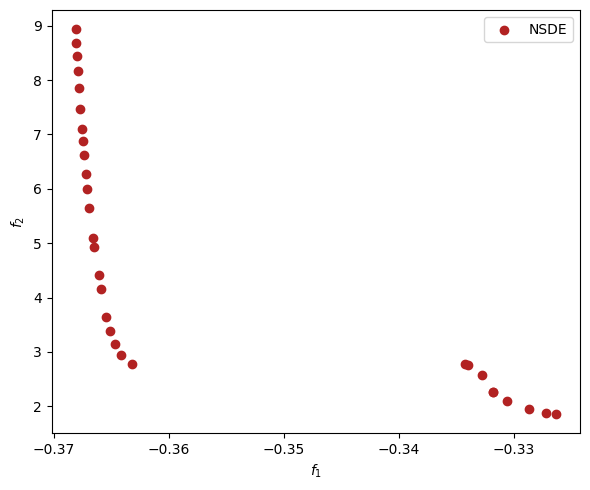

In [77]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsde_problem_2.F[:, 0], res_nsde_problem_2.F[:, 1], color="firebrick", label="NSDE")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [78]:
writer = Video("../images/moo_nsde_x_video.mp4", fps=2)

with Recorder(writer, converter=Matplotlib(dpi=300)) as rec:
    
    for g in range(len(res_nsde_problem_2.history)):

        fig, ax = plt.subplots(figsize=[6, 5], dpi=150)
        
        ranks = res_nsde_problem_2.history[g].pop.get("rank")
        front = ranks == 0
        
        cv = res_nsde_problem_2.history[g].pop.get("CV").flatten()
        infeasible = cv > 0.0

        ax.scatter(res_nsde_problem_2.history[g].pop.get("X")[front, 0],
                   res_nsde_problem_2.history[g].pop.get("X")[front, 1],
                   marker="o", color="black", label="Pareto front")
        
        ax.scatter(res_nsde_problem_2.history[g].pop.get("X")[~(front | infeasible), 0],
                   res_nsde_problem_2.history[g].pop.get("X")[~(front | infeasible), 1],
                   marker="x", color="grey", label="Dominated")
        
        ax.scatter(res_nsde_problem_2.history[g].pop.get("X")[infeasible, 0],
                   res_nsde_problem_2.history[g].pop.get("X")[infeasible, 1],
                   marker="x", color="firebrick", label="Infeasible")
        
        
        ax.legend(framealpha=1.0)

        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        
        _text = make_ordinal(g + 1)
        
        plt.text(0.1, 0.1, f"{_text} gen", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', edgecolor='black'))
        
        ax.set_ylim([-5, 5])
        ax.set_xlim([-5, 5])

        plt.tight_layout()
        
        rec.record()

In [81]:
writer = Video("../images/moo_nsde_f_video.mp4", fps=2)

with Recorder(writer, converter=Matplotlib(dpi=300)) as rec:
    
    for g in range(len(res_nsde_problem_2.history)):

        fig, ax = plt.subplots(figsize=[6, 5], dpi=150)
        
        ranks = res_nsde_problem_2.history[g].pop.get("rank")
        front = ranks == 0
        
        cv = res_nsde_problem_2.history[g].pop.get("CV").flatten()
        infeasible = cv > 0.0

        ax.scatter(res_nsde_problem_2.history[g].pop.get("F")[front, 0],
                   res_nsde_problem_2.history[g].pop.get("F")[front, 1],
                   marker="o", color="black", label="Pareto front")
        
        ax.scatter(res_nsde_problem_2.history[g].pop.get("F")[~(front | infeasible), 0],
                   res_nsde_problem_2.history[g].pop.get("F")[~(front | infeasible), 1],
                   marker="x", color="grey", label="Dominated")
        
        ax.scatter(res_nsde_problem_2.history[g].pop.get("F")[infeasible, 0],
                   res_nsde_problem_2.history[g].pop.get("F")[infeasible, 1],
                   marker="x", color="firebrick", label="Infeasible")
        
        
        ax.legend(framealpha=1.0)

        ax.set_xlabel("$f_1$")
        ax.set_ylabel("$f_2$")
        
        _text = make_ordinal(g + 1)
        
        plt.text(0.1, 0.1, f"{_text} gen", transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', edgecolor='black'))
        
        ax.set_ylim([1, 10])
        ax.set_xlim([-0.37, -0.32])

        plt.tight_layout()
        
        rec.record()

In [351]:
res_gde3_problem_2 = moo_minimize(ProblemF2(),
                                  gde3,
                                  termination_multi,
                                  seed=SEED,
                                  save_history=True,
                                  verbose=False)

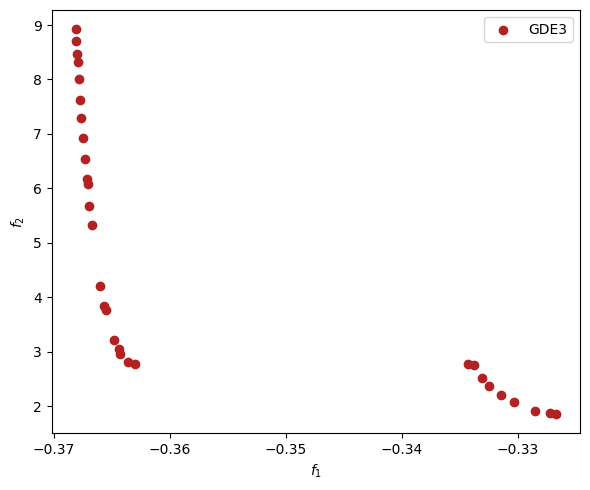

In [352]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_gde3_problem_2.F[:, 0], res_gde3_problem_2.F[:, 1], color="firebrick", label="GDE3")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [353]:
res_nsga2_problem_2 = moo_minimize(ProblemF2(),
                                   nsga2,
                                   termination_multi,
                                   seed=SEED,
                                   save_history=True,
                                   verbose=False)

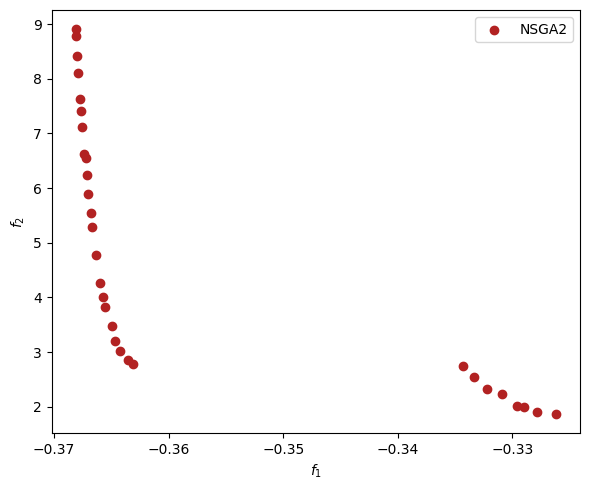

In [354]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsga2_problem_2.F[:, 0], res_nsga2_problem_2.F[:, 1], color="firebrick", label="NSGA2")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

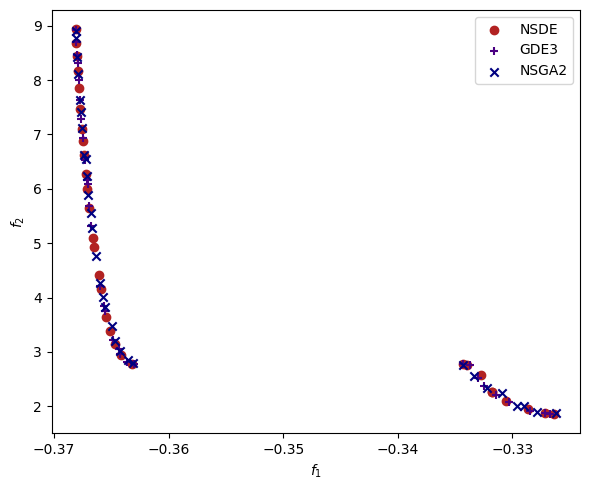

In [355]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsde_problem_2.F[:, 0], res_nsde_problem_2.F[:, 1], color="firebrick", label="NSDE", marker="o")
ax.scatter(res_gde3_problem_2.F[:, 0], res_gde3_problem_2.F[:, 1], color="indigo", label="GDE3", marker="+")
ax.scatter(res_nsga2_problem_2.F[:, 0], res_nsga2_problem_2.F[:, 1], color="navy", label="NSGA2", marker="x")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [356]:
objs_p2 = np.row_stack([res_nsde_problem_2.F, res_gde3_problem_2.F, res_nsga2_problem_2.F])
nadir_f2 = objs_p2.max(axis=0)
reference_p2 = nadir_f2 + 1e-6
ideal_p2 =  objs_p2.min(axis=0)

In [357]:
#Evaluate by Hypervolume
hv_p2 = get_performance_indicator("hv", ref_point=reference_p2, zero_to_one=True,
                                  nadir=nadir_f2, ideal=ideal_p2)

print("hv NSDE", hv_p2.do(res_nsde_problem_2.F))
print("hv GDE3", hv_p2.do(res_gde3_problem_2.F))
print("hv NSGA-II", hv_p2.do(res_nsga2_problem_2.F))

hv NSDE 0.852333996100651
hv GDE3 0.852209656334066
hv NSGA-II 0.8512876593631209


## Other survival operators

In [358]:
dyn_survival = RankSurvival(rule="sqrt", crowding_func="cd")

In [359]:
nsde_dyn = NSDE(pop_size=30, variant="DE/rand/1/bin", F=(0.3, 1.0), CR=0.7, survival=dyn_survival)

In [360]:
res_dyn_nsde_problem_2 = moo_minimize(ProblemF2(),
                                      nsde_dyn,
                                      ('n_gen', NGEN),
                                      seed=SEED,
                                      save_history=True,
                                      verbose=False)

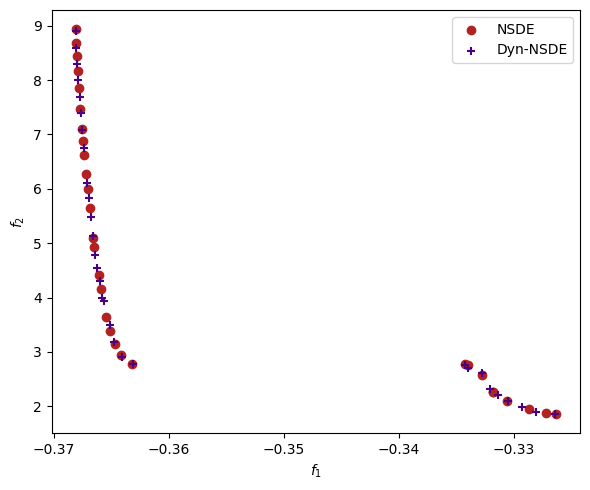

In [361]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)
ax.scatter(res_nsde_problem_2.F[:, 0], res_nsde_problem_2.F[:, 1], color="firebrick", label="NSDE", marker="o")
ax.scatter(res_dyn_nsde_problem_2.F[:, 0], res_dyn_nsde_problem_2.F[:, 1], color="indigo", label="Dyn-NSDE", marker="+")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()

In [362]:
print("hv NSDE", hv_p2.do(res_nsde_problem_2.F))
print("hv Dyn-NSDE", hv_p2.do(res_dyn_nsde_problem_2.F))

hv NSDE 0.852333996100651
hv Dyn-NSDE 0.8531986018827767


## Many-objective problems

In [363]:
class ProblemF3(Problem):

    def __init__(self):
        
        xl = np.full(2, -5.0)
        xu = np.full(2, 5.0)

        super().__init__(n_var=2, n_obj=3, n_constr=2, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        
        F1 = (x[:, 0] - 0.5) ** 2 + 0.7 * x[:, 0] * x[:, 1] + 1.2 * (x[:, 1] + 0.7) ** 2
        
        A = np.array([[1, 0.3],
                  [0.3, 0.7]])
    
        xt = x.dot(A)
        
        rugosity_1 = (xt[:, 0] * np.sin(15 * xt[:, 0]) - 0.5) ** 2 + (xt[:, 1] * np.sin(15 * xt[:, 1]) - 2) ** 2
        rugosity_2 = np.sin(15 * x[:, 0]) ** 2 + np.sin(25 * x[:, 1]) ** 2
        
        F2 = 5 * rugosity_2 + rugosity_1 + F1
        
        B = np.array([[-1, 0.7],
                  [0.5, -0.3]])
        
        xt2 = x.dot(B)
        
        F3 = (xt2[:, 0] - 0.5) ** 2 + 0.7 * xt2[:, 0] * xt2[:, 1] + 1.2 * (xt2[:, 1] + 0.7) ** 2
        
        out["F"] = np.column_stack([F1, F2, F3])
        
        G1 = x[:, 0] ** 2 + (x[:, 1] - 1) ** 2 - 10
        G2 = -x[:, 0] ** 2 - (x[:, 1] - 1) ** 2 + 1
        out["G"] = np.column_stack([G1, G2])

In [376]:
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=10)

popsize = ref_dirs.shape[0] +ref_dirs.shape[0] % 4

In [371]:
#Define the reference directions
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=10)

nsder = NSDER(ref_dirs, pop_size=popsize, variant="DE/rand/1/bin", F=(0.3, 1.0), CR=0.7)
nsga3 = NSGA3(ref_dirs, pop_size=popsize)

In [379]:
res_nsder_problem_3 = moo_minimize(ProblemF3(),
                                   nsder,
                                   ('n_gen', NGEN),
                                   seed=SEED,
                                   save_history=True,
                                   verbose=False)

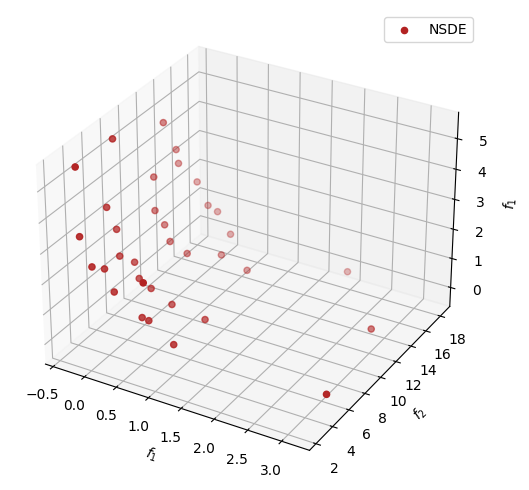

In [380]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100, subplot_kw={'projection':'3d'})
ax.scatter(res_nsder_problem_3.F[:, 0], res_nsder_problem_3.F[:, 1], res_nsder_problem_3.F[:, 2],
           color="firebrick", label="NSDE", marker="o")
ax.set_ylabel("$f_2$")
ax.set_xlabel("$f_1$")
ax.set_zlabel("$f_1$")
ax.legend()
fig.tight_layout()
plt.show()